### Chihuahua Or Muffin

![Title](ressources/preview.jpg)

#### Import des librairies de travail

In [1]:
import os 
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
# Représentation graphique
import matplotlib.pyplot as plt
# Commande pour afficher les plots inline
%matplotlib inline
# import our image opening tool
from PIL import Image 
# import progress bars to show train progress
from tqdm import tnrange, tqdm_notebook 
from glob import glob
from math import floor

In [2]:
# Pytorch framework deep learning
import torch
# Extension Torchvision pour la gestion des datasets
from torchvision import datasets, models, transforms
# nn = Neural Network (définir les couches)
import torch.nn as nn
# Fonctions special
from torch.nn import functional as F
# Optimiseurs
import torch.optim as optim

#### Construction du réseau de neurones

Un réseau de neurone ressemble généralement à ce qui suit. Le nombre de neurones de sortie correspond au nombre de classes (ici 2 : chihuahua et muffin).

![Title](ressources/what_is_nn_slide.jpg)

In [3]:
class MySkynet(nn.Module):
    """
    A very basic neural network.
    """
    def __init__(self, input_dim=(3, 224, 224)):
        """
        Constructs a neural network.
        
        input_dim: a tuple that represents "channel x height x width" dimensions of the input
        """
        super().__init__()
        # the total number of RGB pixels in an image is the tensor's volume
        num_in_features = input_dim[0] * input_dim[1] * input_dim[2]
        # input layer
        self.layer_0 = nn.Linear(num_in_features, 128)
        # hidden layers
        self.layer_1 = nn.Linear(128, 64)
        self.layer_2= nn.Linear(64, 32)
        # output layer, output size of 2 for chihuahua and muffin
        self.layer_3= nn.Linear(32, 2)

    def forward(self, x):
        """
        Define the forward pass through our network.
        """
        batch_size = x.shape[0]
        # convert our RGB tensor into one long vector
        x = x.view(batch_size, -1)
        
        # pass through our layers
        x = F.relu(self.layer_0(x))
        x = F.relu(self.layer_1(x))
        x = F.relu(self.layer_2(x))
        x = F.relu(self.layer_3(x))
        
        # convert the raw output to probability predictions
        x = F.softmax(x, dim=1)
        
        return x

Le réseau de neurones étant défini, il faut l'initialiser. Si disponible, nous allons essayer d'utiliser le GPU; sinon le CPU.

In [4]:
# cuda:0 signifie le premier trouvé
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
model = MySkynet().to(device)                      
# load our simple neural network
model

MySkynet(
  (layer_0): Linear(in_features=150528, out_features=128, bias=True)
  (layer_1): Linear(in_features=128, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=32, bias=True)
  (layer_3): Linear(in_features=32, out_features=2, bias=True)
)

Voici à quoi ressemble notre réseau : 

![Title](ressources/architecture.png)

#### Datasets

Il est nécessaire d'avoir deux jeux de données différents. Un pour l'entrainement de notre modèle; et un autre pour le tester.

In [5]:
print("Data contents:", os.listdir("data"))
print("Train contents:", os.listdir("data/train"))
print("Validation contents:", os.listdir("data/validation"))

Data contents: ['train', 'validation']
Train contents: ['chihuahua', 'muffin']
Validation contents: ['chihuahua', 'muffin']


Regardons quelques unes de nos images : 

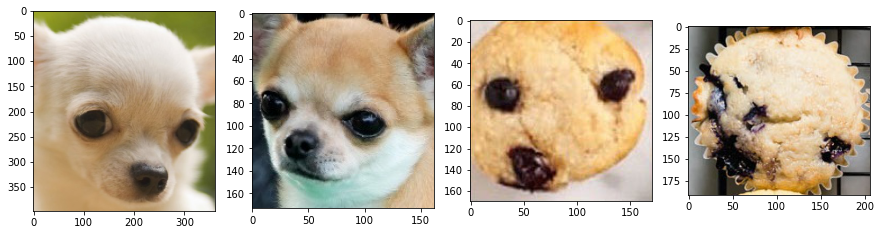

In [6]:
_, ax = plt.subplots(1, 4, figsize=(15,60))  
# to show 4 images side by side, make a "1 row x 4 column" axes
ax[0].imshow(Image.open("data/train/chihuahua/4.jpg"))
ax[1].imshow(Image.open("data/train/chihuahua/5.jpg"))
ax[2].imshow(Image.open("data/train/muffin/131.jpg"))
ax[3].imshow(Image.open("data/train/muffin/107.jpg"))

Notre séparation jeux d'entrainement et de test est en 80/20. 120 images pour l'entrainement et 30 images pour la validation.

![Title](ressources/folders.png)

##### Chargement des données

Il faut maintenant charger nos images et les convertir pour les rendre compréhensibles pour notre réseau de neurones. 

PyTorch utilise des objets Tensor (matrices multidimensionnelles - Nd arrays).

Pour convertir les images en tensors, on va passer par un "Dataloader". Le dataloader organise nos données pour que le modèle puisse les utiliser. 

![Title](ressources/image_to_tensor.jpg)

Il faut tout d'abord définir des "transformations" pour convertir nos images en tensors. Et cela, pour nos deux datasets (train/test).

In [7]:
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                 std=[0.5, 0.5, 0.5])

# transforms for our training data
train_transforms = transforms.Compose([
    # resize to resnet input size
    transforms.Resize((224,224)),
    # transform image to PyTorch tensor object
    transforms.ToTensor(),
    normalize
])

# these validation transforms are exactly the same as our train transforms
validation_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
])

print("Train transforms:", train_transforms)

Train transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)


Ensuite, il faut créer les datasets en passing les transformations dans le constructeur ImageFolder().

In [8]:
image_datasets = {
    'train':
        datasets.ImageFolder('data/train', train_transforms),
    'validation':
        datasets.ImageFolder('data/validation', validation_transforms)}

print("==Train Dataset==\n", image_datasets["train"])
print()
print("==Validation Dataset==\n", image_datasets["train"])

==Train Dataset==
 Dataset ImageFolder
    Number of datapoints: 120
    Root location: data/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

==Validation Dataset==
 Dataset ImageFolder
    Number of datapoints: 120
    Root location: data/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )


Enfin, créer les dataloaders à partir des datasets.

In [9]:
dataloaders = {
    'train':
        torch.utils.data.DataLoader(
            image_datasets['train'],
            batch_size=8,
            shuffle=True,
            num_workers=4),
    'validation':
        torch.utils.data.DataLoader(
            image_datasets['validation'],
            batch_size=8,
            shuffle=False,
            num_workers=4)}

print("Train loader:", dataloaders["train"])
print("Validation loader:", dataloaders["validation"])

Train loader: <torch.utils.data.dataloader.DataLoader object at 0x000001E5E6DD7340>
Validation loader: <torch.utils.data.dataloader.DataLoader object at 0x000001E5E09CC940>


Un dataloader renvoie deux choses : un tensor pour représenter une image et un vecteur pour représenter les labels (0 ou 1).

![Title](ressources/training_testing_pipeline.png)

#### Entrainer le modèle

Nous avons le réseau de neurones et les données. Il faut maintenant entrainer le modèle en itérant sur les données.

![Title](ressources/backpropagation.gif)

Pour obtenir un meilleur résultat il faut que notre réseau de neurones puissent s'entrainer plusieurs fois. On va donc passer nos données via de multiples epochs. 

Après chaque epoch, on vérifie comment notre modèle performe sur le jeu de validation pour suivre ses progrès.

In [10]:
def train_model(model, dataloaders, loss_function, optimizer, num_epochs):
    """
    Trains a model using the given loss function and optimizer, for a certain number of epochs.
    
    model: a PyTorch neural network
    loss_function: a mathematical function that compares predictions and labels to return an error
    num_epochs: the number of times to run through the full training dataset
    """
    # train for n epochs. an epoch is a full iteration through our dataset
    for epoch in tnrange(num_epochs, desc="Total progress", unit="epoch"):
        # print a header
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('----------------')

        # first train over the dataset and update weights; at the end, calculate our validation performance
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval() 

            # keep track of the overall loss and accuracy for this batch
            running_loss = 0.0
            running_corrects = 0

             # iterate through the inputs and labels in our dataloader
            # (the tqdm_notebook part is to display a progress bar)
            for inputs, labels in tqdm_notebook(dataloaders[phase], desc=phase, unit="batch", leave=False):
                # move inputs and labels to appropriate device (GPU or CPU)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # FORWARD PASS
                outputs = model(inputs)
                # compute the error of the model's predictions
                loss = loss_function(outputs, labels)

                if phase == 'train':
                    # BACKWARD PASS
                    optimizer.zero_grad()  # clear the previous gradients
                    loss.backward()        # backpropagate the current error gradients
                    optimizer.step()       # update the weights (i.e. do the learning)

                # track our accumulated loss
                running_loss += loss.item() * inputs.size(0)
                # track number of correct to compute accuracy
                _, preds = torch.max(outputs, 1)
                running_corrects += torch.sum(preds == labels.data)
                
                # print our progress
            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])
            print(f'{phase} error: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

        print()

Une dernière chose à faire : définir une fonction qui nous renseigne sur la performance de notre modèle. C'est la fonction de perte (loss function) qui compare les prédictions du modèle aux vrais labels.

Une fois la perte (l'erreur) calculée, on doit définir comment notre modèle doit réagir à ce feedback. Un optimiseur détermine comment le réseau de neurones apprend du feedback.

In [11]:
loss_function = nn.CrossEntropyLoss()              
# the most common error function in deep learning
optimizer = optim.SGD(model.parameters(), lr=0.1)  
# Stochastic Gradient Descent, with a learning rate of 0.1

![Title](ressources/gradient_descent.gif)

Action !

In [14]:
train_model(model, dataloaders, loss_function, optimizer, num_epochs=3)

<ipython-input-10-0f2f39ac3159>:10: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for epoch in tnrange(num_epochs, desc="Total progress", unit="epoch"):


Total progress:   0%|          | 0/3 [00:00<?, ?epoch/s]

Epoch 1/3
----------------


<ipython-input-10-0f2f39ac3159>:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, labels in tqdm_notebook(dataloaders[phase], desc=phase, unit="batch", leave=False):


train:   0%|          | 0/15 [00:00<?, ?batch/s]

train error: 0.3875, Accuracy: 0.9333


validation:   0%|          | 0/4 [00:00<?, ?batch/s]

validation error: 0.4784, Accuracy: 0.8333

Epoch 2/3
----------------


train:   0%|          | 0/15 [00:00<?, ?batch/s]

train error: 0.4105, Accuracy: 0.9000


validation:   0%|          | 0/4 [00:00<?, ?batch/s]

validation error: 0.4674, Accuracy: 0.8333

Epoch 3/3
----------------


train:   0%|          | 0/15 [00:00<?, ?batch/s]

train error: 0.3771, Accuracy: 0.9417


validation:   0%|          | 0/4 [00:00<?, ?batch/s]

validation error: 0.4671, Accuracy: 0.8333



On observe désormais l'accuracy qui correspond au score de notre modèle (fréquence de prédiction correcte).

On peut visualiser les prédictions de notre modèle comme suit : 

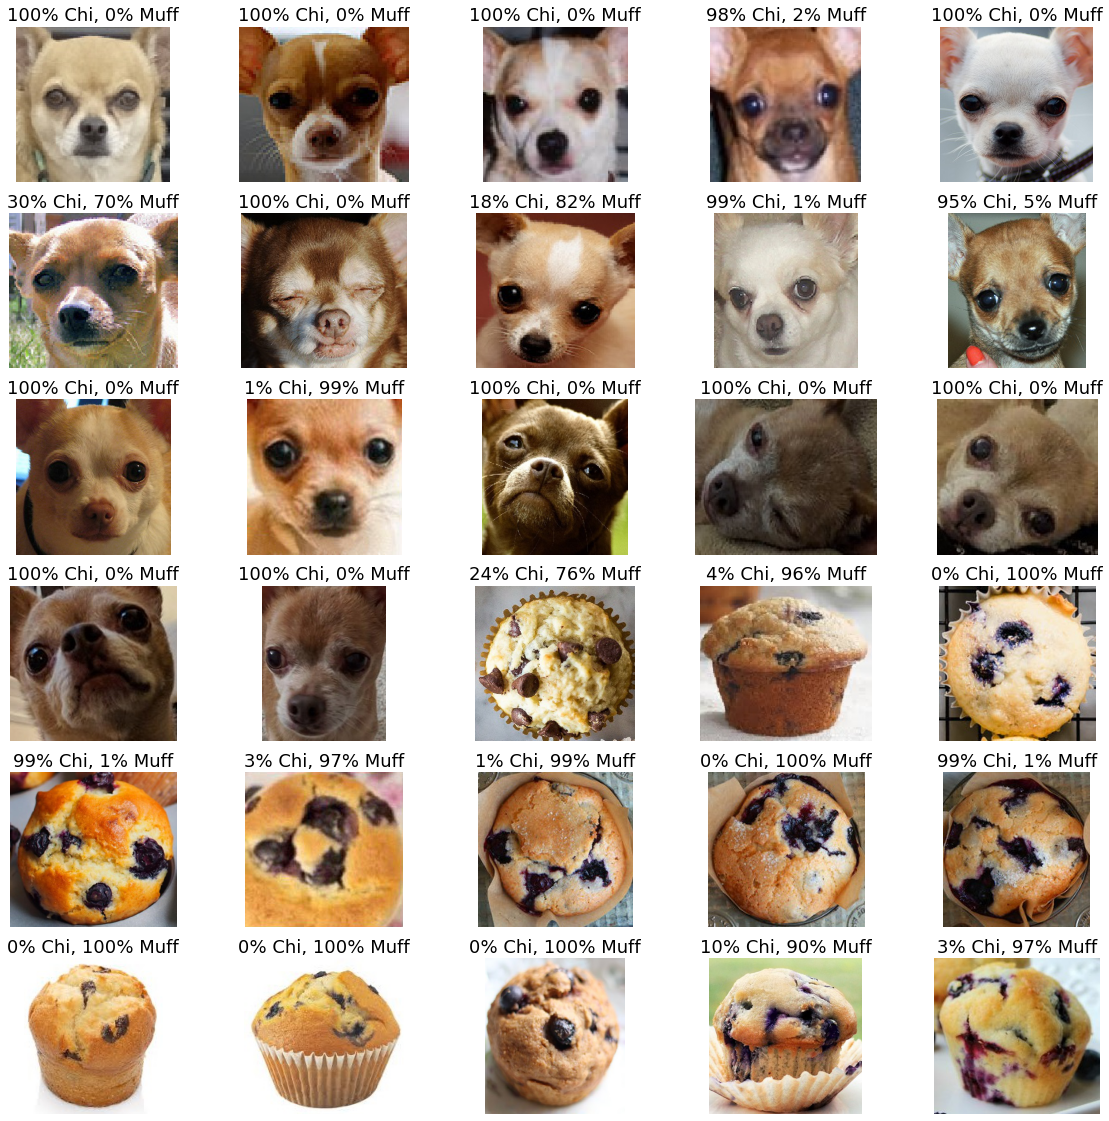

In [15]:
# get all the images from our validation sets
validation_img_paths = glob("data/validation/**/*.jpg", recursive=True)
images = [Image.open(img_path) for img_path in validation_img_paths]

# put all the images together to run through our model
validation_batch = torch.stack( [validation_transforms(img).to(device) for img in images])
pred_logits_tensor = model(validation_batch)
pred_probs = pred_logits_tensor.cpu().data.numpy()

# show the probabilities for each picture
fig, axs = plt.subplots(6, 5, figsize=(20, 20))
for i, img in enumerate(images):
    ax = axs[floor(i/5)][i % 5]
    ax.axis('off')
    ax.set_title("{:.0f}% Chi, {:.0f}% Muff".format(100*pred_probs[i,0], 100*pred_probs[i,1]), fontsize=18)
    ax.imshow(img)